## Read the fly larva connectome of the following publication and represent as a ConnectivityMatrix:
Winding et al., 2023 - The connectome of an insect brain.
Science: https://www.science.org/doi/10.1126/science.add9330 

The connectome data can be obtained from the pages of the original publication at the journal Science. Under the following link:
https://www.science.org/doi/suppl/10.1126/science.add9330/suppl_file/science.add9330_data_s1_to_s4.zip 

Download and extract the zip file here, please. 

### Read neuron info. 
Notably, in the raw data corresponding neurons in the left and right hemisphere are represented in the same row.
We instead split them into separate rows.

In [1]:
import pandas
import numpy

fn_neurons = "data/science.add9330_data_s1_to_s4/science.add9330_data_s2.csv"

neurons_raw = pandas.read_csv(fn_neurons)
str_id_left = "left_id"; str_id_right = "right_id"

neurons_left = neurons_raw.loc[neurons_raw[str_id_left] != "no pair"].rename(columns={str_id_left: "id"})
neurons_left["hemisphere"] = "left"
neurons_left = neurons_left[neurons_left.columns.drop(str_id_right)]

neurons_right = neurons_raw.loc[neurons_raw[str_id_right] != "no pair"].rename(columns={str_id_right: "id"})
neurons_right["hemisphere"] = "right"
neurons_right = neurons_right[neurons_right.columns.drop(str_id_left)]

neurons = pandas.concat([neurons_left, neurons_right], axis=0)
neurons["id"] = neurons["id"].apply(lambda _x: int(_x))
neurons = neurons.sort_values("id").reset_index(drop=True)

neuron_cols = neurons.columns.drop("id")
neurons

,id,celltype,additional_annotations,level_7_cluster,hemisphere
0,29,KC,KC,42,right
1,37365,sensory,visual,0,left
2,40045,sensory,olfactory,2,left
3,40152,sensory,gut,63,left
4,677717,KC,KC,49,right
...,...,...,...,...,...
2605,21300466,pre-DN-SEZ,no official annotation,62,left
2606,21590958,pre-DN-VNC,no official annotation,14,right
2607,21591033,PN-somato,mechano-Ch 2nd_order PN,18,right
2608,21591037,pre-DN-VNC,no official annotation,14,right


### Read connectivity matrices.
We read the connectivity data and convert it.
This is done in two functions. 

The first finds neuron skeleton ids that are used in the connectivity matrices that are not in the table of neuron properties for whatever reason. And fills in dummy data (mostly "unknown") for them.
The second one converts the matrices into a sparse representation, associates the connections with their types (axo-dendritic, etc.) and concatenates the four connectomes. Note that they can be split apart later easily using the .filter method with their type.

In [2]:
from scipy import sparse

def fill_in_missing_neurons(neurons, dict_raw_mats):
    default = {"celltype": "unknown", "additional_annotations": "unknown",
               "level_7_cluster": "no cluster", "hemisphere": "unknown"}
    
    lst_raw_mats = list(dict_raw_mats.values())
    mis_ids = []
    for con_raw in lst_raw_mats:
        id_x = list(map(int, con_raw.columns.values))
        id_y = list(map(int, con_raw.index.values))
        assert(numpy.all(numpy.array(id_x) == numpy.array(id_y)))

        mis_ids.extend([_x for _x in id_x if _x not in neurons["id"].values])
    mis_ids = numpy.unique(mis_ids)
    mis_entries = [default.copy() for _x in mis_ids]
    [_x.update({"id": _id}) for _x, _id in zip(mis_entries, mis_ids)]
    mis_entries = pandas.DataFrame.from_records(mis_entries)

    neurons = pandas.concat([neurons, mis_entries], axis=0).sort_values("id").reset_index(drop=True)
    return neurons

def to_edge_dataframe(neurons, dict_raw_mats):
    neuron_bins = numpy.hstack([neurons["id"].values, neurons["id"].values[-1] + 1])

    res = []
    for tp_raw, con_raw in dict_raw_mats.items():
        id_x = list(map(int, con_raw.columns.values))
        id_y = list(map(int, con_raw.index.values))
        assert(numpy.all(numpy.array(id_x) == numpy.array(id_y)))
        assert numpy.in1d(id_x, neurons["id"]).all()
        idxx = numpy.digitize(id_x, bins=neuron_bins) - 1
        assert len(numpy.unique(idxx)) == len(idxx)

        tmp_M = sparse.coo_matrix(con_raw.values)
        df = pandas.DataFrame({"row": idxx[tmp_M.row], "col": idxx[tmp_M.col],
                               "count": tmp_M.data, "type": [tp_raw for _x in range(tmp_M.nnz)]})
        res.append(df)
    return pandas.concat(res, axis=0).reset_index(drop=True)
            

Execute the actual reading and conversion

In [3]:
dict_con_files = {"axo-dendritic": "data/science.add9330_data_s1_to_s4/Supplementary-Data-S1/ad_connectivity_matrix.csv",
                  "axo-axonic": "data/science.add9330_data_s1_to_s4/Supplementary-Data-S1/aa_connectivity_matrix.csv",
                  "dendro-dendritic": "data/science.add9330_data_s1_to_s4/Supplementary-Data-S1/dd_connectivity_matrix.csv",
                  "dendro-axonic": "data/science.add9330_data_s1_to_s4/Supplementary-Data-S1/da_connectivity_matrix.csv"}
dict_con_data = dict([(_k, pandas.read_csv(_v, index_col=0)) for _k, _v in dict_con_files.items()])

neurons_augmented = fill_in_missing_neurons(neurons, dict_con_data)
edges = to_edge_dataframe(neurons_augmented, dict_con_data)
edge_indices = edges[["row", "col"]]
edge_properties = edges[edges.columns.drop(["row", "col"])]

Turn into ConnectivityMatrix object

In [4]:
import conntility

M = conntility.ConnectivityMatrix(edge_indices, edge_properties=edge_properties,
                                  vertex_properties=neurons_augmented, 
                                  default_edge_property="count",
                                  shape=(len(neurons_augmented), len(neurons_augmented)))

To get e.g. only the axo-dendritic connections.
Note that the order of neurons along the rows / cols is changed from the original data.

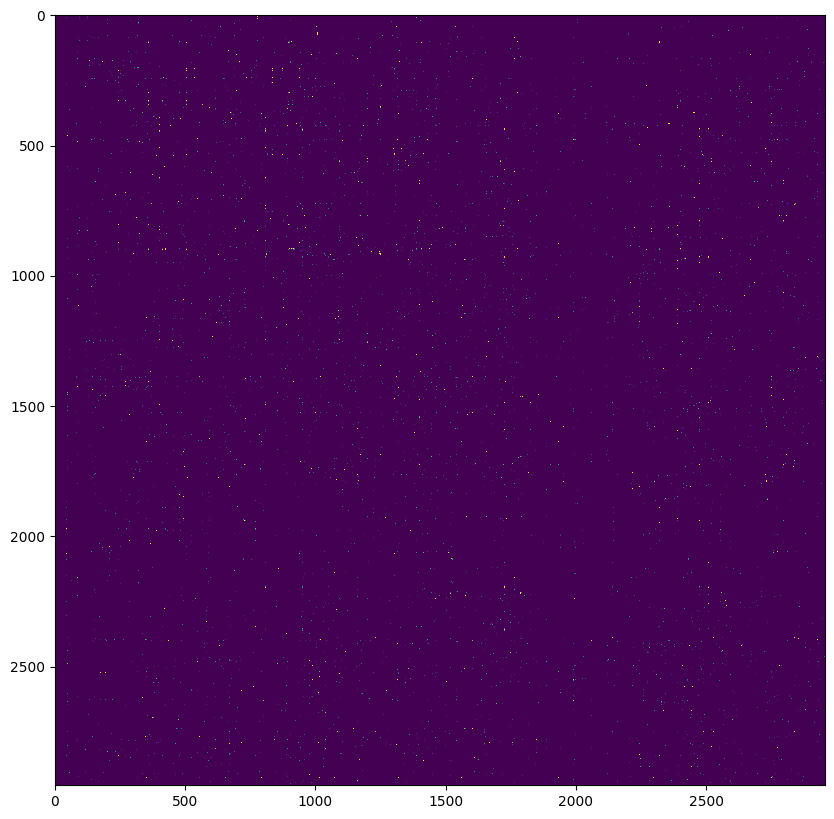

In [5]:
from matplotlib import pyplot as plt

mat = M.filter("type").eq("axo-dendritic")

plt.figure(figsize=(10, 10)).gca().imshow(mat.array, interpolation="nearest", clim=[0, 10])

Same, but only the left hemisphere

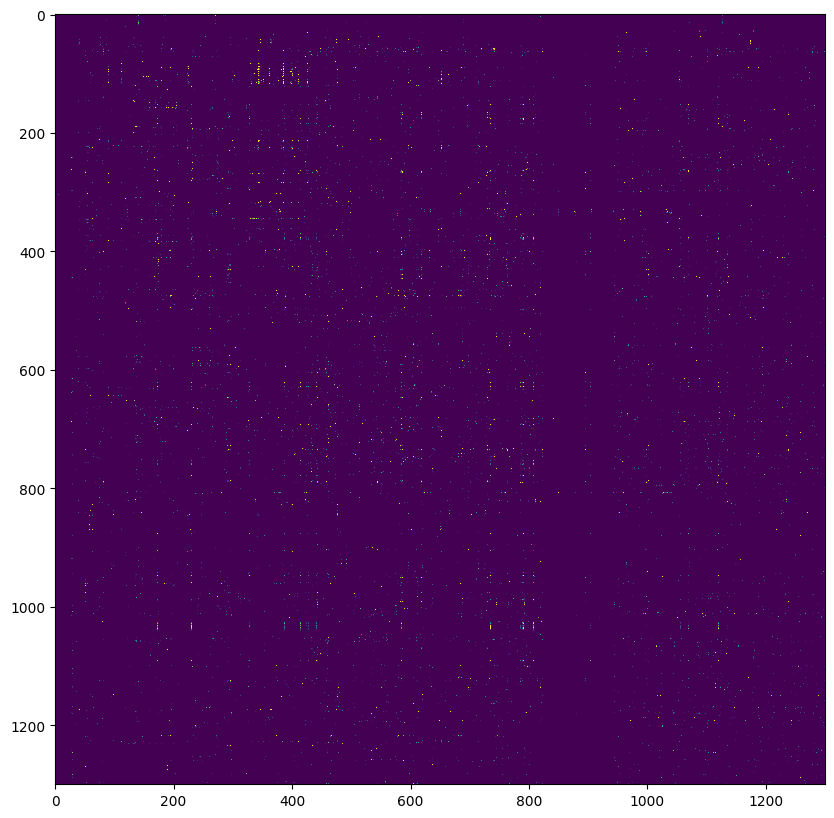

In [6]:
mat = M.index("hemisphere").eq("left").filter("type").eq("axo-dendritic")

plt.figure(figsize=(10, 10)).gca().imshow(mat.array, interpolation="nearest", clim=[0, 10])

Getting the original order back

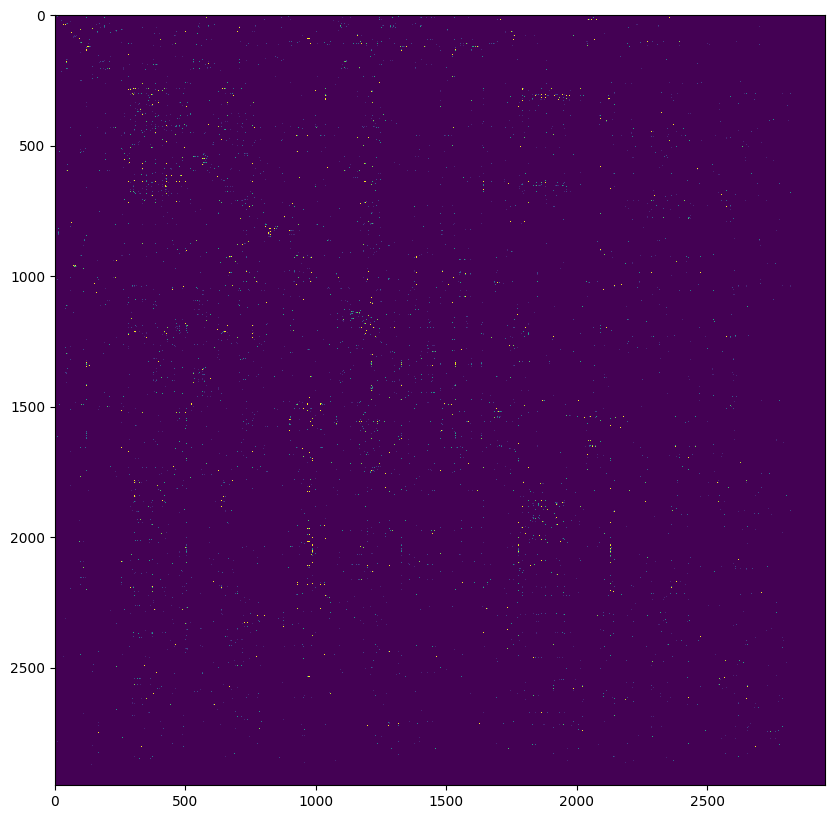

In [7]:
mat = M.filter("type").eq("axo-dendritic")
mat = mat.reorder("id", order=dict_con_data["axo-dendritic"].index.values)

plt.figure(figsize=(10, 10)).gca().imshow(mat.array, interpolation="nearest", clim=[0, 10])

Sort by annotated cluster

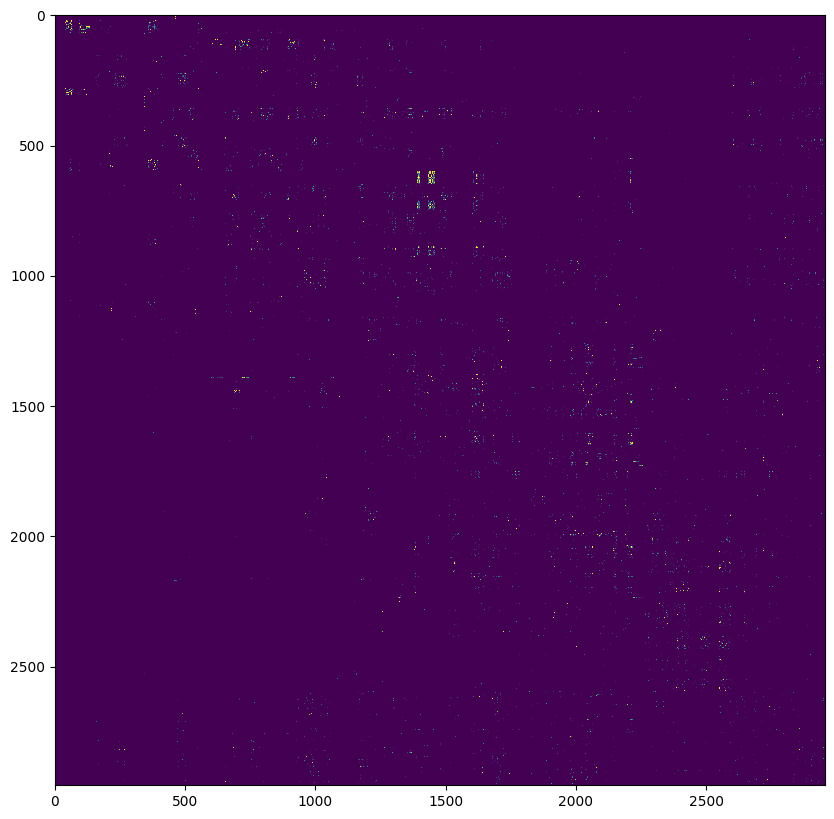

In [8]:
mat = M.filter("type").eq("axo-dendritic").reorder("level_7_cluster")

plt.figure(figsize=(10, 10)).gca().imshow(mat.array, interpolation="nearest", clim=[0, 10])